# Regressione lineare multipla

## Ottenimento del dataset

C:\Users\HP\AppData\Local\Temp\ipykernel_24316\1872363506.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-whitegrid')


Contenuto del DataFrame:
   UserID  Age  Gender       VRHeadset   Duration  MotionSickness  \
0       1   40       2        HTC Vive  13.598508               8   
1       2   43       1        HTC Vive  19.950815               2   
2       3   27       2  PlayStation VR  16.543387               4   
3       4   33       2        HTC Vive  42.574083               6   
4       5   51       2  PlayStation VR  22.452647               4   

   ImmersionLevel  
0               5  
1               2  
2               2  
3               3  
4               2  


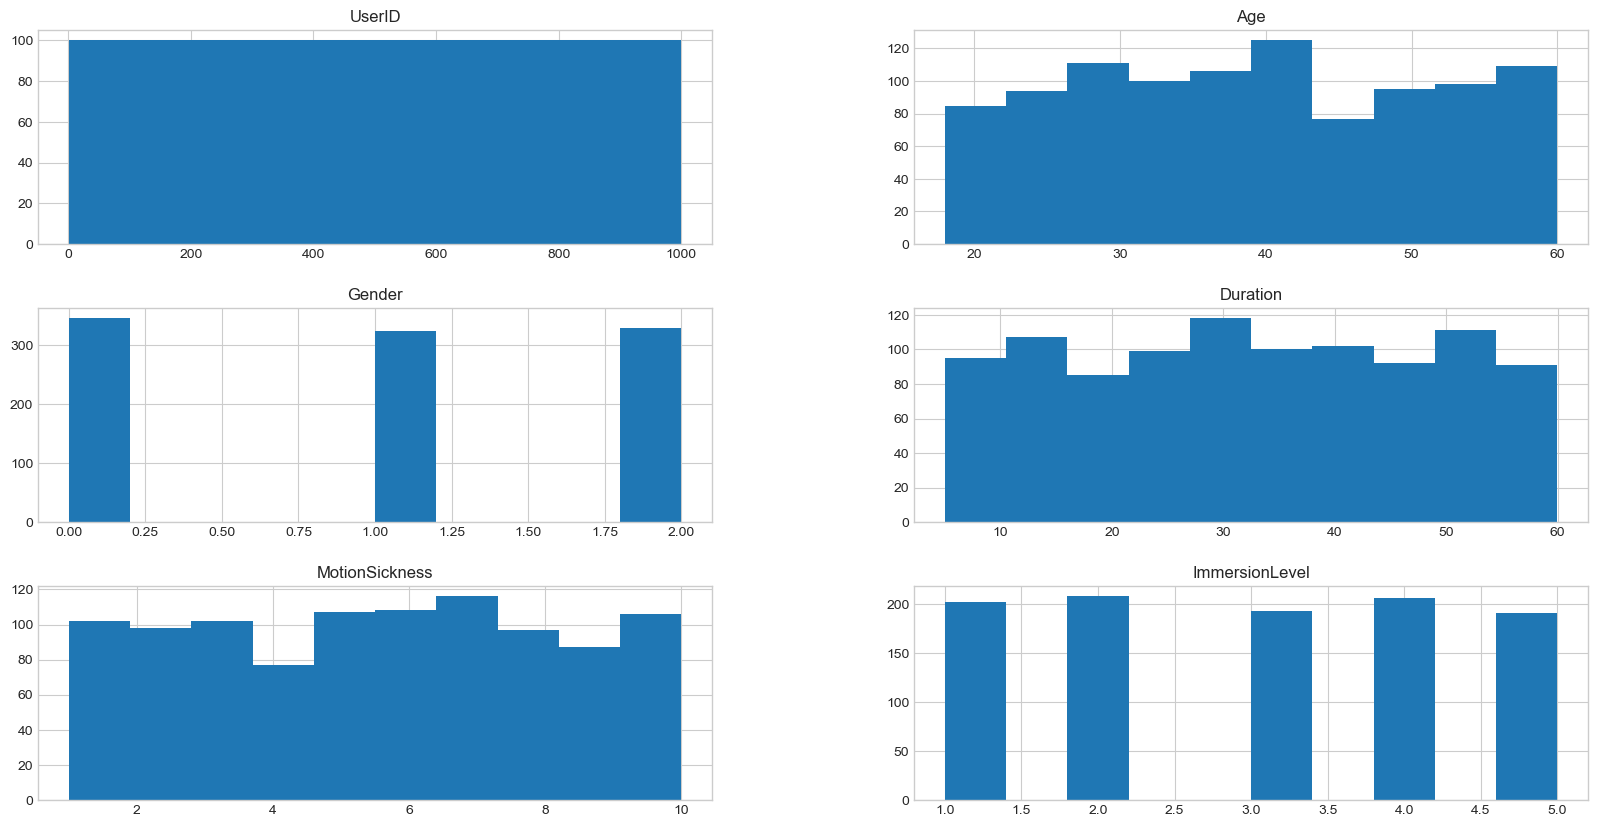

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from six.moves import urllib
import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20, 10)

FILE_PATH = "dataset"
FILE_NAME = "data.csv"
CSV_PATH = os.path.join(FILE_PATH, FILE_NAME)

# Definisco df come variabile globale
df = None

def fetch_file_data1():
    global df  # Dichiarazione di df come variabile globale
    # Check if the file exists
    if not os.path.isfile(CSV_PATH):
        print(f"File {FILE_NAME} non trovato nel percorso {FILE_PATH}")
        return
    
    # Read the dataset from the CSV file
    df = pd.read_csv(CSV_PATH)
    
    # Print the content of the DataFrame
    print("Contenuto del DataFrame:")
    print(df.head())
    
    # Visualizza l'istogramma
    df.hist()
    plt.show()

# Chiamata alla funzione per caricare il dataset e visualizzare l'istogramma
fetch_file_data1()


## 1)DataCleaning

### 1.1) Descrizione del dataset

In [2]:
#descrizione dataset
df.describe()

UserID          Age       Gender     Duration  MotionSickness  \
count  1000.000000  1000.000000  1000.000000  1000.000000     1000.000000   
mean    500.500000    39.178000     0.983000    32.576660        5.526000   
std     288.819436    12.050208     0.821819    15.764659        2.866625   
min       1.000000    18.000000     0.000000     5.008672        1.000000   
25%     250.750000    29.000000     0.000000    18.733748        3.000000   
50%     500.500000    39.000000     1.000000    32.368611        6.000000   
75%     750.250000    49.000000     2.000000    45.343732        8.000000   
max    1000.000000    60.000000     2.000000    59.983723       10.000000   

       ImmersionLevel  
count     1000.000000  
mean         2.976000  
std          1.409756  
min          1.000000  
25%          2.000000  
50%          3.000000  
75%          4.000000  
max          5.000000

### 1.2) Verifica valori null nel dataset

In [3]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

UserID            False
Age               False
Gender            False
VRHeadset         False
Duration          False
MotionSickness    False
ImmersionLevel    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [4]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

UserID            False
Age               False
Gender            False
VRHeadset         False
Duration          False
MotionSickness    False
ImmersionLevel    False
dtype: bool

### 1.4) Data Plot

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

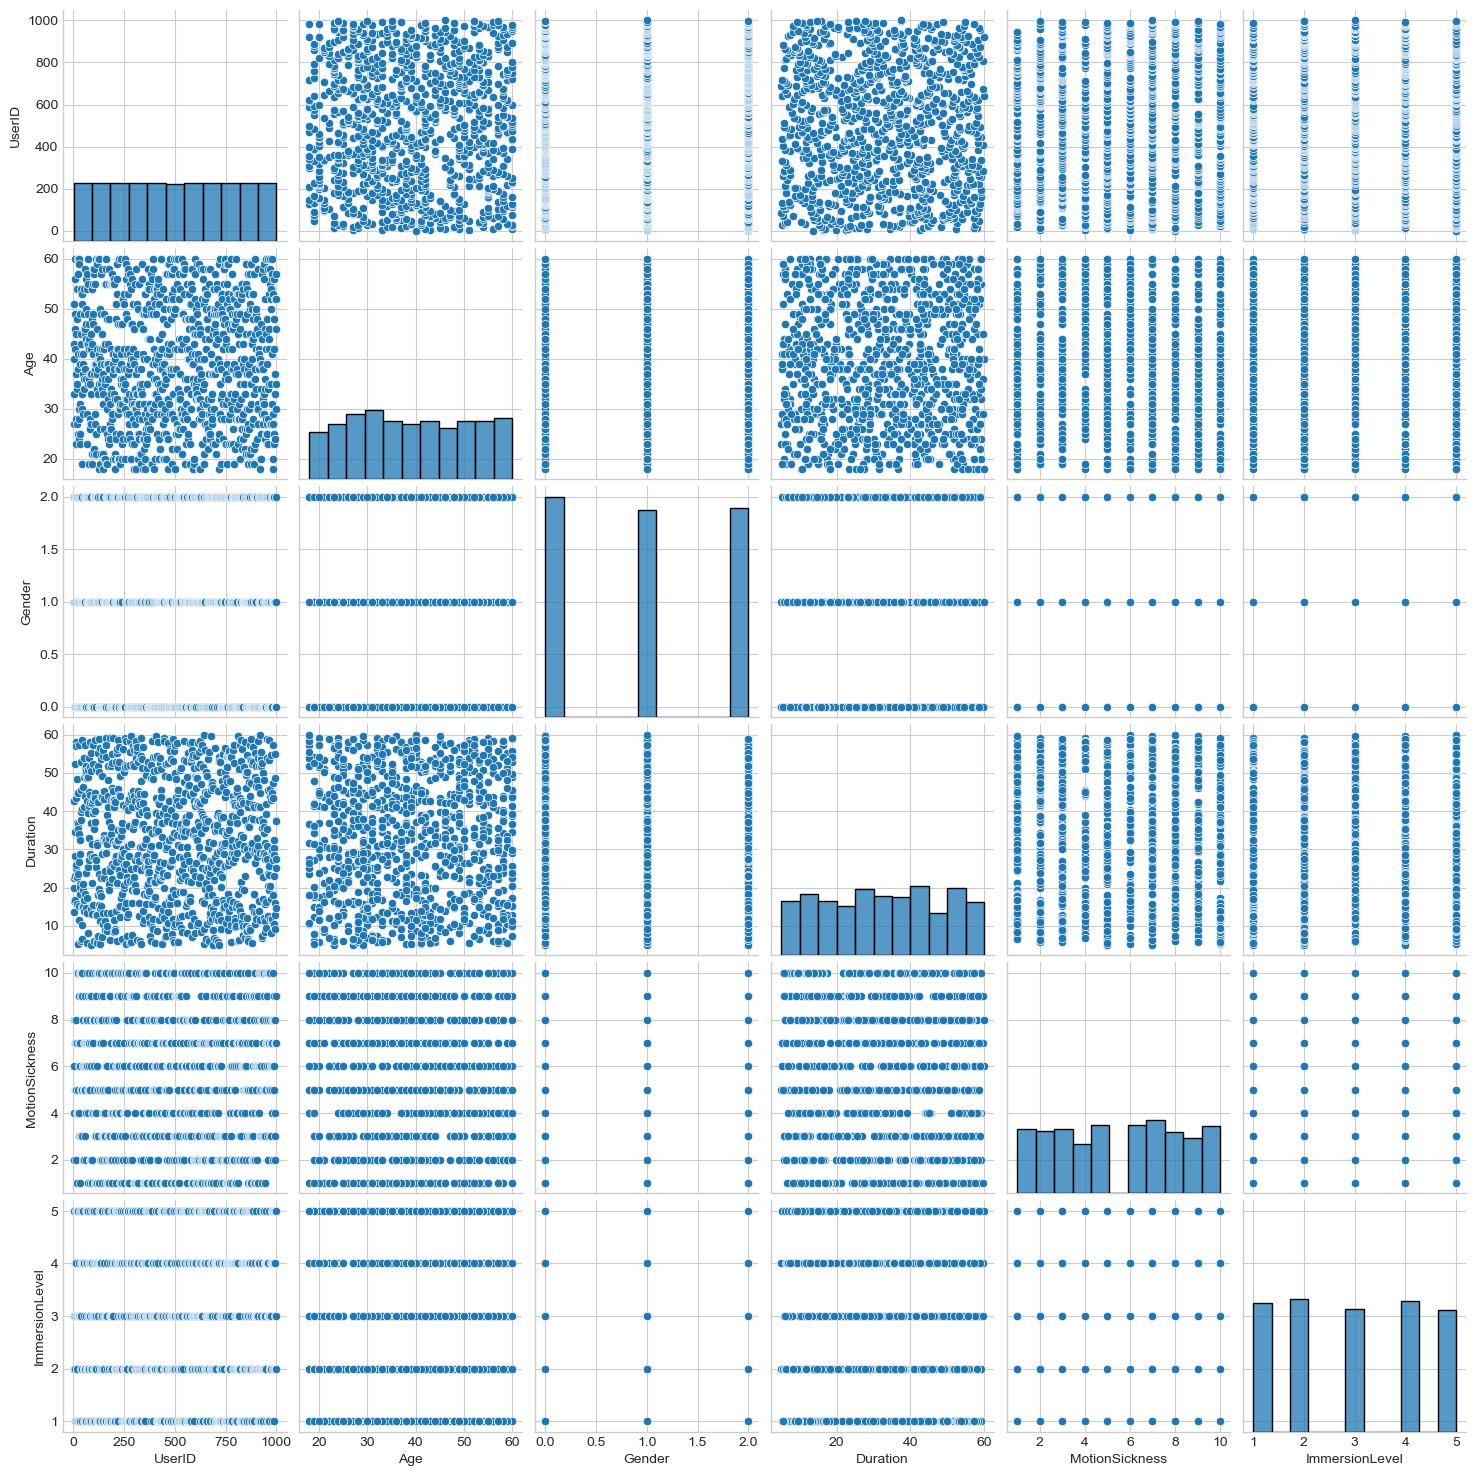

In [5]:
#data plot visualizzare dipendenze tra variabili
sb.pairplot(df)
#salvataggio plot
plt.savefig('pairplor.png')

### 1.5) Plot Linearità e Multicollinearità

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


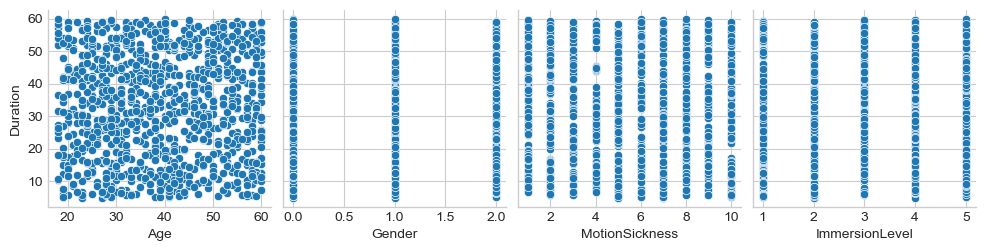

In [6]:
#Data plot su un sottoinsieme preso in esame
sb.pairplot(df,x_vars=["Age","Gender", "MotionSickness", "ImmersionLevel"], y_vars=["Duration"])
#salvataggio linear plot
plt.savefig('linearPlot.png')

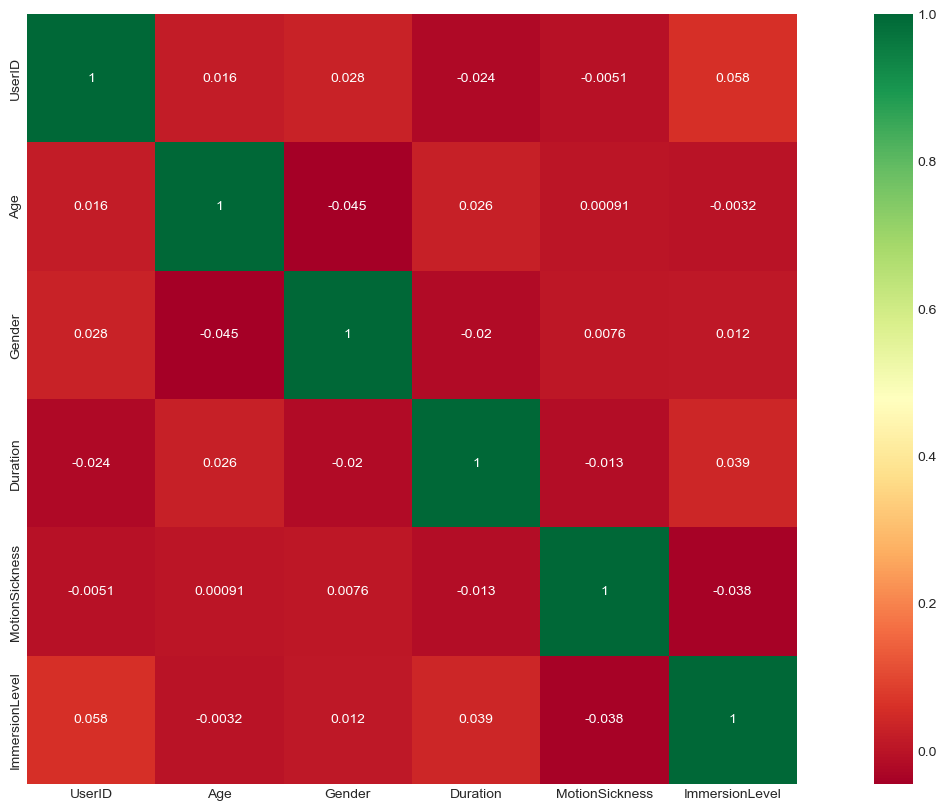

In [7]:
# Rimuovi la colonna 'HTC Vive'
df_numeric = df.drop(columns=['VRHeadset'])

# Calcola la correlazione tra le variabili numeriche rimanenti
correlation_matrix = df_numeric.corr()

# Visualizza la heatmap della correlazione
sb.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", square=True)
plt.show()

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) Definizione classe Metrics

In [8]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse

  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

### 2.2) Definizione classe MetricsResultContainer

In [9]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

class MetricsResultContainer:
    meanMAE = []
    meanMSE = []
    meanRMSE = []

    def __init__(self, model, alg, scaler, param, metricsMean):
        self.model = model
        self.alg = alg
        self.scaler = scaler
        self.param = param
        self.metricsMean = metricsMean
        self.meanMAE = []
        self.meanMSE = []
        self.meanRMSE = []
        

    def printMetrics(self):
        for m in self.metricsMean:
            self.meanMAE.append(m.mae)
            self.meanMSE.append(m.mse)
            self.meanRMSE.append(m.rmse)
        print("meanMAE=", np.mean(self.meanMAE))
        print("meanMSE=", np.mean(self.meanMSE))
        print("meanRMSE=", np.mean(self.meanRMSE))
        

    # funzione per mostrare la normalità dei residui e l'omoschedasticità
    def visualizza_grafici(self):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))  # Una riga, due colonne

        # Istogramma dei Residui
        axs[0].hist(self.meanMAE, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
        axs[0].set_title('Istogramma dei Residui')
        axs[0].set_xlabel('Residui')
        axs[0].set_ylabel('Densità')

        # Grafico Scatter dei Residui
        lunghezza_dati = len(self.meanMAE)
        axs[1].scatter(np.arange(1, lunghezza_dati + 1), self.meanMAE, color='blue', alpha=0.7)
        axs[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axs[1].set_title('Grafico Scatter dei Residui')
        axs[1].set_xlabel('Predizioni')
        axs[1].set_ylabel('Residui')

        plt.tight_layout()  # Assicura una corretta disposizione dei grafici senza sovrapposizioni
        plt.show()

        

### 2.3) Istanziazione funzioni per Regressione

In [10]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.base import clone

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.base import Visualizer

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

from termcolor import colored as cl

#funzione per generare il modello, divisione training e test, features scaling, selection
def generateModel(alg, scaler, model, select):
  #array di metriche (MAE,MSE,RMSE)
  metrics1 = []
  #generazione n_split test/trainig sets
  #uso algoritmo per dividere i dati di raining da quelli di test
  for train_index, test_index in alg.split(X,y):
    clone_model = clone(model)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    #applicazione feature selection su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)

    #training dell'algoritmo sui training set
    clone_model.fit(X_train_z,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = clone_model.predict(X_test_z)
    modelCopy = copy.copy(clone_model)
    #calcolo metriche predizione
    metrics1.append(
        Metrics1(metrics.mean_absolute_error(y_test,y_pred),
                 metrics.mean_squared_error(y_test,y_pred),
                 np.sqrt(metrics.mean_squared_error(y_test,y_pred))
                 )
        )
  return metrics1

#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns=['Duration','VRHeadset',"UserID"])
y=df.Duration
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione deve essere il 30% della lunghezza del dataset
k= (k/(k*0.3))
#Kf divisione dataset per k gruppi per testare mediante due algoritmi Kfold-RepeateKFold
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=100, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni  di utilizzo della ram messa a disposizione da google
rkfRF = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_regression, k=4)
#risultati: array di array di metriche
metricsResults = []

## 3) Model Testing

### 3.1) Linear Regression

Linear Regression - ZScore Normalization - KF
meanMAE= 13.622985564569529
meanMSE= 249.80359305503552
meanRMSE= 15.800181038007418


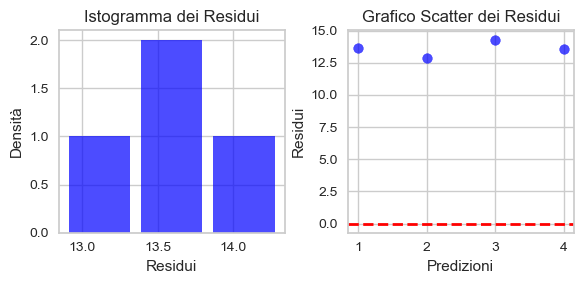


Linear Regression - ZScore Normalization - RKF
meanMAE= 13.634142945346818
meanMSE= 250.36006039096523
meanRMSE= 15.816827963496912


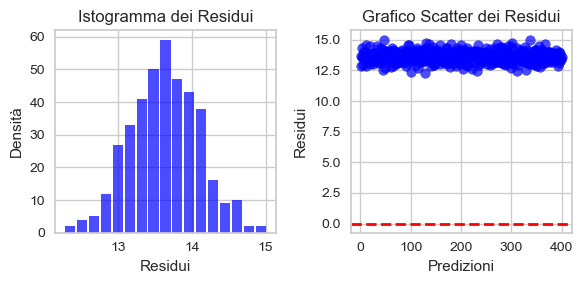


Linear Regression - MinMax Normalization - KF
meanMAE= 13.622985564569529
meanMSE= 249.80359305503552
meanRMSE= 15.800181038007418


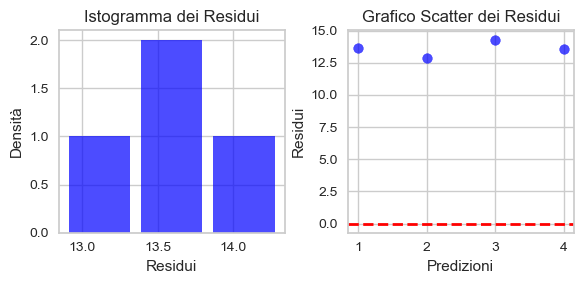


Linear Regression - MinMax Normalization - RKF
meanMAE= 13.634142945346818
meanMSE= 250.36006039096523
meanRMSE= 15.816827963496912


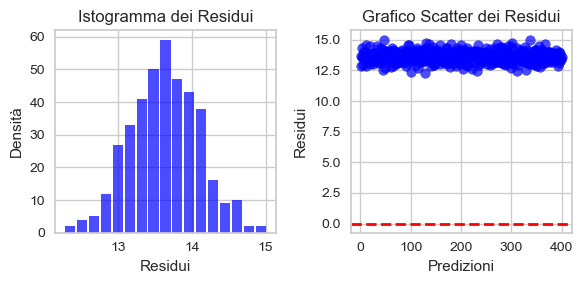


Linear Regression - RobustScaler Normalization - KF
meanMAE= 13.622985564569529
meanMSE= 249.80359305503552
meanRMSE= 15.800181038007418


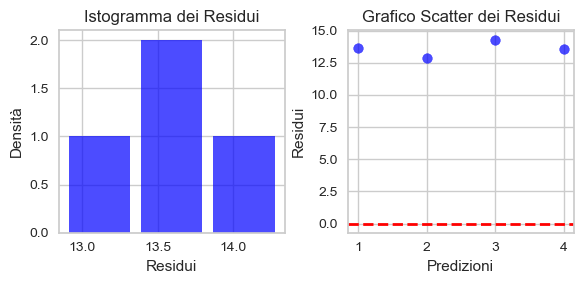


Linear Regression - RobustScaler Normalization - RKF
meanMAE= 13.634142945346818
meanMSE= 250.36006039096523
meanRMSE= 15.816827963496912


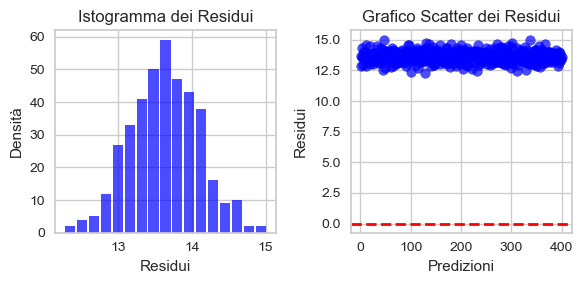

In [11]:
from sklearn.linear_model import LinearRegression
#Linear Regression
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
print("Linear Regression - ZScore Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
m.visualizza_grafici()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e RKFold
print("\nLinear Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
m.visualizza_grafici()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minimax e KFold
print("\nLinear Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
m.visualizza_grafici()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minmax e RKFold
print("\nLinear Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
m.visualizza_grafici()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e KFold
print("\nLinear Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
m.visualizza_grafici()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e RKFold
print("\nLinear Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
m.visualizza_grafici()

### 3.2) DecisionTree Regression

In [12]:
#utilizziamo DecisionTree Regression
from sklearn.tree import DecisionTreeRegressor
print("DecisionTreeRegressor - ZScore Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - ZScore Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e RKFold
m.printMetrics()

print("\nDecisionTreeRegressor - MinMax Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minimax e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - MinMax Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minmax e RKFold
m.printMetrics()

print("\nDecisionTreeRegressor - RobustScaler Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - RobustScaler Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","Robust","Default",
  generateModel(rkf, RobustScaler(), DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e RKFold
m.printMetrics()

DecisionTreeRegressor - ZScore Normalization - KF
meanMAE= 18.92142098894208
meanMSE= 515.065143845661
meanRMSE= 22.685937635472104

DecisionTreeRegressor - ZScore Normalization - RKF
meanMAE= 18.584991221574317
meanMSE= 509.5276264591492
meanRMSE= 22.5613146324515

DecisionTreeRegressor - MinMax Normalization - KF
meanMAE= 19.130502971149888
meanMSE= 524.4540062182762
meanRMSE= 22.88775142780436

DecisionTreeRegressor - MinMax Normalization - RKF
meanMAE= 18.608088604026758
meanMSE= 510.1829649379538
meanRMSE= 22.57610395844392

DecisionTreeRegressor - RobustScaler Normalization - KF
meanMAE= 19.00405383098698
meanMSE= 516.7632345603931
meanRMSE= 22.725911793380412

DecisionTreeRegressor - RobustScaler Normalization - RKF
meanMAE= 18.569222955855736
meanMSE= 508.59145735971754
meanRMSE= 22.54100651123439


### 3.3) Lasso Regression

In [13]:
#Utilizzo Lasso regression
from sklearn import linear_model
lassoReg = linear_model.Lasso()
print("Lasso Regression - ZScore Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()


Lasso Regression - ZScore Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - ZScore Normalization - RKF
meanMAE= 13.591765359099913
meanMSE= 248.80255253460302
meanRMSE= 15.770766940779303

Lasso Regression - MinMax Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - MinMax Normalization - RKF
meanMAE= 13.591523956925153
meanMSE= 248.79603324590443
meanRMSE= 15.770556928532544

Lasso Regression - RobustScaler Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - RobustScaler Normalization - RKF
meanMAE= 13.591523956925153
meanMSE= 248.79603324590443
meanRMSE= 15.770556928532544


### 3.4) Ridge Regression

In [14]:
#Utilizzo Ridge Regression
from sklearn import linear_model
bridgeReg = linear_model.Ridge()
print("Ridge Regression - ZScore Normalization - KF")
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
m = MetricsResultContainer("Ridge Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()


print("\nRidge Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Ridge Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Ridge Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()


Ridge Regression - ZScore Normalization - KF
meanMAE= 13.622925371245794
meanMSE= 249.80115857095655
meanRMSE= 15.800103279847283

Ridge Regression - ZScore Normalization - RKF
meanMAE= 13.627606087751131
meanMSE= 250.12743148218058
meanRMSE= 15.812750726955498

Ridge Regression - MinMax Normalization - KF
meanMAE= 13.622459934049637
meanMSE= 249.7835507078821
meanRMSE= 15.799545503719658

Ridge Regression - MinMax Normalization - RKF
meanMAE= 13.626992614984609
meanMSE= 250.10058379539797
meanRMSE= 15.811899813248885

Ridge Regression - RobustScaler Normalization - KF
meanMAE= 13.622781096295856
meanMSE= 249.79550107897538
meanRMSE= 15.799923230470986

Ridge Regression - RobustScaler Normalization - RKF
meanMAE= 13.627386244447752
meanMSE= 250.1183821966306
meanRMSE= 15.812465072012092


### 3.5) Random Forest Regression

In [15]:
#Utilizzo Foresta regression
from sklearn.ensemble import RandomForestRegressor

print("RandomForestRegressor - ZScore Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
  generateModel(kf, StandardScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - ZScore Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
  generateModel(rkfRF, StandardScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - MinMax Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor- MinMax Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - RobustScaler Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - RobustScaler Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

RandomForestRegressor - ZScore Normalization - KF
meanMAE= 14.506699465807518
meanMSE= 300.0150808052931
meanRMSE= 17.317473959469737

RandomForestRegressor - ZScore Normalization - RKF
meanMAE= 14.531862124150708
meanMSE= 300.4948861311432
meanRMSE= 17.32924368764492

RandomForestRegressor - MinMax Normalization - KF
meanMAE= 14.538256780231213
meanMSE= 302.666675122975
meanRMSE= 17.394393648053274

RandomForestRegressor- MinMax Normalization - RKF
meanMAE= 14.52184262025353
meanMSE= 300.74630273937896
meanRMSE= 17.33708105003702

RandomForestRegressor - RobustScaler Normalization - KF
meanMAE= 14.618510224434566
meanMSE= 303.53356610323885
meanRMSE= 17.417315177844902

RandomForestRegressor - RobustScaler Normalization - RKF
meanMAE= 14.522857956242586
meanMSE= 300.73874545013956
meanRMSE= 17.337117601759736


### 3.6) SVR Regression

In [16]:
#Utilizzo SVR Regression
from sklearn.svm import SVR
print("SVR - ZScore Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - ZScore Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - MinMax Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR- MinMax Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RobustScaler Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RobustScaler Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

SVR - ZScore Normalization - KF
meanMAE= 13.711906608492066
meanMSE= 253.85640785379283
meanRMSE= 15.927497648067082

SVR - ZScore Normalization - RKF
meanMAE= 13.693209436216248
meanMSE= 253.25402278561867
meanRMSE= 15.911115101436872

SVR - MinMax Normalization - KF
meanMAE= 13.708951491478315
meanMSE= 253.73213251090226
meanRMSE= 15.924035179902607

SVR- MinMax Normalization - RKF
meanMAE= 13.69007645332325
meanMSE= 253.1771115169163
meanRMSE= 15.908680657391544

SVR - RobustScaler Normalization - KF
meanMAE= 13.70853358293215
meanMSE= 253.27096381135974
meanRMSE= 15.909382469370192

SVR - RobustScaler Normalization - RKF
meanMAE= 13.695186125045423
meanMSE= 252.91018959804174
meanRMSE= 15.900453278603438


## 4) Creazione pipeline di machine learning

In [17]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
# Adattamento e trasformazione dei dati con RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Creazione del modello di regressione con LassoRegression
model = lassoReg
model.fit(X_scaled, y)

# Creazione del PMMLPipeline con il modello già addestrato
pipeline = PMMLPipeline([("Regression", model)])
#estrazione pipiline in file .pmml
sklearn2pmml(pipeline, "RegressoreDurataMeeting.pmml", with_repr = True)